In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
import sklearn
import numpy as np

sklearn.set_config(display="diagram")

X_train = pd.read_csv("./titanic_dataset/train.csv")
X_test = pd.read_csv("./titanic_dataset/test.csv")

In [221]:
y_train = X_train['Survived']
X_train.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin", "Survived"], inplace=True)

X_train.loc[X_train["Sex"] == "male", "Sex"] = 1
X_train.loc[X_train["Sex"] == "female", "Sex"] = 0
X_train["Sex"] = X_train["Sex"].astype("int64")

In [222]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import SGDClassifier

num_pipeline = make_pipeline(
    (SimpleImputer(missing_values=np.nan, strategy="median")),
    (StandardScaler()) 
)

cat_pipeline = make_pipeline(
    (SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    (OneHotEncoder())
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

sgd_clf = make_pipeline(preprocessing, SGDClassifier())
sgd_clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x288f5b820>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x288f5b8e0>)])),
                ('sgdclassifier', SGDClassifier())])

In [223]:
def some_passenger(idx):
    return pd.DataFrame(X_train.iloc[idx:idx+1,:], columns=X_train.columns)

def predict_some_passenger(idx, clf):
    prediction = clf.predict(some_passenger(idx))
    return prediction, y_train.iloc[idx]

In [224]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

cv_score_sgd = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
cm_clf = confusion_matrix(y_train, y_train_pred)
cm_clf

array([[467,  82],
       [133, 209]])

In [225]:
from sklearn.ensemble import RandomForestClassifier 

forest_clf = make_pipeline(preprocessing, RandomForestClassifier())
forest_clf.fit(X_train, y_train)

cv_score_forest = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")
cv_score_forest

y_train_probas = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
y_train_probas

array([[0.87, 0.13],
       [0.01, 0.99],
       [0.66, 0.34],
       ...,
       [0.52, 0.48],
       [0.73, 0.27],
       [0.53, 0.47]])

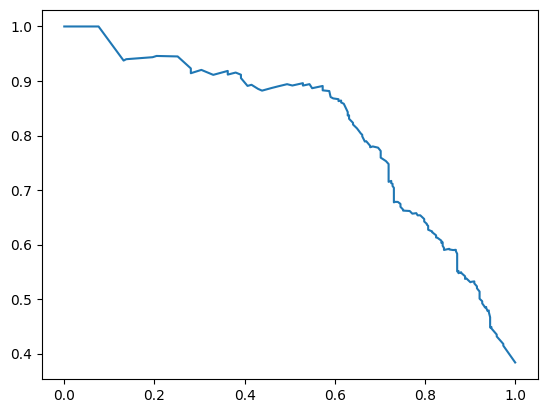

In [226]:
from sklearn.metrics import precision_recall_curve

y_scores_forest = y_train_probas[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

plt.plot(recalls, precisions)
plt.show()

In [227]:
X_test.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
X_test.loc[X_test["Sex"] == "male", "Sex"] = 1
X_test.loc[X_test["Sex"] == "female", "Sex"] = 0
X_test["Sex"] = X_test["Sex"].astype("int64")

forest_clf.predict(X_test)

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,